## Import Required Packages

In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import PIL
import os
import random
import shutil

## Get Image Feature and Slide Labels

### Input Data Pipeline 1 - Directly Get Image Features and Ground Truth Slide-Level Labels from TFRecords

In [2]:
def get_data_from_tf(tf_path):
    feature = {'height': tf.io.FixedLenFeature([], tf.int64),
               'width': tf.io.FixedLenFeature([], tf.int64),
               'depth': tf.io.FixedLenFeature([], tf.int64),
               'label': tf.io.FixedLenFeature([], tf.int64),
               'image/format': tf.io.FixedLenFeature([], tf.string),
               'image_name': tf.io.FixedLenFeature([], tf.string),
               'image/encoded': tf.io.FixedLenFeature([], tf.string),
               'image_feature': tf.io.FixedLenFeature([], tf.string)}

    tfrecord_dataset = tf.data.TFRecordDataset(tf_path)

    def _parse_image_function(key):
        return tf.io.parse_single_example(key, feature)

    CLAM_dataset = tfrecord_dataset.map(_parse_image_function)

    Image_Features = list()

    for tfrecord_value in CLAM_dataset:
        img_features = tf.io.parse_tensor(tfrecord_value['image_feature'], 'float32')
        slide_labels = tfrecord_value['label']
        slide_label = int(slide_labels)
        Image_Features.append(img_features)

    return Image_Features, slide_label

### Input Data Pipeline 2 - Compute Image Features from Image Array parsed from TFRecords

In [3]:
def parse_tf(tf_path):
    feature = {'height': tf.io.FixedLenFeature([], tf.int64),
               'width': tf.io.FixedLenFeature([], tf.int64),
               'depth': tf.io.FixedLenFeature([], tf.int64),
               'label': tf.io.FixedLenFeature([], tf.int64),
               'image/format': tf.io.FixedLenFeature([], tf.string),
               'image_name': tf.io.FixedLenFeature([], tf.string),
               'image/encoded': tf.io.FixedLenFeature([], tf.string)}

    tfrecord_dataset = tf.data.TFRecordDataset(tf_path)

    def _parse_image_function(key):
        return tf.io.parse_single_example(key, feature)

    CLAM_dataset = tfrecord_dataset.map(_parse_image_function)

    Img = list()

    for tfrecord_value in CLAM_dataset:
        img = tf.io.decode_image(tfrecord_value['image/encoded'])
        slide_labels = tfrecord_value['label']
        slide_label = int(slide_labels)
        Image_Shape = img.shape

    return Img, Image_Shape, slide_label

In [4]:
def customize_resnet(input_shape=(512, 512, 3)):
    ## Load the ResNet50 model
    resnet50_model = tf.keras.applications.resnet50.ResNet50(include_top=False,weights='imagenet',input_shape=input_shape)
    resnet50_model.trainable = False  ## Free Training

    ## Create a new Model based on original resnet50 model ended after the 3rd residual block
    layer_name = 'conv4_block1_0_conv'
    res50 = tf.keras.Model(inputs=resnet50_model.input, outputs=resnet50_model.get_layer(layer_name).output)

    ## Add adaptive mean-spatial pooling after the new model
    adaptive_mean_spatial_layer = tf.keras.layers.GlobalAvgPool2D()
    
    return res50, adaptive_mean_spatial_layer

In [5]:
def get_img_feature(img_array, res50, adaptive_mean_spatial_layer):
    Image_Features = list()
    for i in range(len(img_array)):
        image_np = np.array(img_array[i])
        image_batch = np.expand_dims(image_np, axis=0)
        image_patch = tf.keras.applications.resnet50.preprocess_input(image_batch.copy())
        predicts = res50.predict(image_patch)
        features = adaptive_mean_spatial_layer(predicts)

        img_features = features.numpy()
        img_features = tf.convert_to_tensor(img_features)
        
        Image_Features.append(img_features)
        
    return Image_Features

## Shuffle Dataset and Split into Training, Validation, and Testing Set

In [6]:
tfrecord = '/research/bsi/projects/PI/tertiary/Hart_Steven_m087494/s211408.DigitalPathology/Quincy/Data/CLAM/TFRECORD_ICIAR2018'
clam_dir = '/research/bsi/projects/PI/tertiary/Hart_Steven_m087494/s211408.DigitalPathology/Quincy/Data/CLAM'

In [7]:
def dataset_shuffle(dataset, path, percent=[0.8,0.1,0.1]):
    """
    Input Arg:
        dataset -> path where all tfrecord data stored
        path -> path where you want to save training, testing, and validation data folder
    """
    
    # return training, validation, and testing path name
    train = path + '/train'
    valid = path + '/valid'
    test = path + '/test'
    
    # create training, validation, and testing directory only if it is not existed
    if os.path.exists(train) == False:
        os.mkdir(os.path.join(clam_dir,'train'))
    if os.path.exists(valid) == False:
        os.mkdir(os.path.join(clam_dir,'valid'))
    if os.path.exists(test) == False:
        os.mkdir(os.path.join(clam_dir,'test'))
    
    total_num_data = len(os.listdir(dataset))
 
    # only shuffle the data when train, validation, and test directory are all empty
    if len(os.listdir(train)) == 0 & len(os.listdir(valid)) == 0 & len(os.listdir(test)) == 0:
        train_names = random.sample(os.listdir(dataset), int(total_num_data*percent[0]))  
        for i in train_names:
            train_srcpath = os.path.join(dataset, i)
            shutil.copy(train_srcpath, train)
        
        valid_names = random.sample(list(set(os.listdir(dataset)) - set(os.listdir(train))), int(total_num_data*percent[1]))
        for j in valid_names:
            valid_srcpath = os.path.join(dataset, j)
            shutil.copy(valid_srcpath, valid)
        
        test_names = list(set(os.listdir(dataset)) - set(os.listdir(train)) - set(os.listdir(valid)))
        for k in test_names:
            test_srcpath = os.path.join(dataset, k)
            shutil.copy(test_srcpath, test)

In [8]:
dataset_shuffle(tfrecord, clam_dir, percent=[0.7,0.15,0.15])

## Load CLAM Model

### Import None-Gated Attention Network

In [9]:
# None-Gated Attention Network Class - assign the same weights of each attention head/layer
class NG_Att_Net(tf.keras.Model):
    def __init__(self, dim_features=1024, dim_compress_features=512, n_hidden_units=256, n_classes=2,
                 dropout=False, dropout_rate=.25):
        super(NG_Att_Net, self).__init__()
        self.dim_features = dim_features
        self.dim_compress_features = dim_compress_features
        self.n_hidden_units = n_hidden_units
        self.n_classes = n_classes
        self.dropout = dropout
        self.dropout_rate = dropout_rate

        self.compression_model = tf.keras.models.Sequential()
        self.model = tf.keras.models.Sequential()

        self.fc_compress_layer = tf.keras.layers.Dense(units=dim_compress_features, activation='relu',
                                                       input_shape=(dim_features,), kernel_initializer='glorot_normal',
                                                       bias_initializer='zeros', name='Fully_Connected_Layer')

        self.compression_model.add(self.fc_compress_layer)
        self.model.add(self.fc_compress_layer)

        self.att_layer1 = tf.keras.layers.Dense(units=n_hidden_units, activation='tanh',
                                                input_shape=(dim_compress_features,),
                                                kernel_initializer='glorot_normal', bias_initializer='zeros',
                                                name='Attention_Layer1')

        self.att_layer2 = tf.keras.layers.Dense(units=n_classes, activation='linear', input_shape=(n_hidden_units,),
                                                kernel_initializer='glorot_normal', bias_initializer='zeros',
                                                name='Attention_Layer2')

        self.model.add(self.att_layer1)

        if dropout:
            self.model.add(tf.keras.layers.Dropout(dropout_rate, name='Dropout_Layer'))

        self.model.add(self.att_layer2)

    def att_compress_model_no_gate(self):
        return self.compression_model

    def att_model_no_gate(self):
        return self.model

    def compress(self, x):
        h = list()
        for i in x:
            c_imf = self.compression_model(i)
            h.append(c_imf)
        return h

    def call(self, x):
        A = list()
        for i in x:
            a = self.model(i)
            A.append(a)
        return A

### Import Gated Attention Network

In [10]:
# Gated Attention Network Class - scaling the weights of each attention head/layer -> weights of each attention layer
# would be different
class G_Att_Net(tf.keras.Model):
    def __init__(self, dim_features=1024, dim_compress_features=512, n_hidden_units=256, n_classes=2,
                 dropout=False, dropout_rate=.25):
        super(G_Att_Net, self).__init__()
        self.dim_features = dim_features
        self.dim_compress_features = dim_compress_features
        self.n_hidden_units = n_hidden_units
        self.n_classes = n_classes
        self.dropout = dropout
        self.dropout_rate = dropout_rate

        self.compression_model = tf.keras.models.Sequential()
        self.model1 = tf.keras.models.Sequential()
        self.model2 = tf.keras.models.Sequential()
        self.model = tf.keras.models.Sequential()

        # GlorotNormal <==> Xavier for weights initialization
        self.fc_compress_layer = tf.keras.layers.Dense(units=dim_compress_features, activation='relu',
                                                       input_shape=(dim_features,), kernel_initializer='glorot_normal',
                                                       bias_initializer='zeros', name='Fully_Connected_Layer')

        self.compression_model.add(self.fc_compress_layer)
        self.model1.add(self.fc_compress_layer)
        self.model2.add(self.fc_compress_layer)

        self.att_layer1 = tf.keras.layers.Dense(units=n_hidden_units, activation='tanh', input_shape=(dim_features,),
                                                kernel_initializer='glorot_normal', bias_initializer='zeros',
                                                name='Attention_Layer1')

        self.att_layer2 = tf.keras.layers.Dense(units=n_hidden_units, activation='sigmoid', input_shape=(dim_features,),
                                                kernel_initializer='glorot_normal', bias_initializer='zeros',
                                                name='Attention_Layer2')

        self.att_layer3 = tf.keras.layers.Dense(units=n_classes, activation='linear', input_shape=(n_hidden_units,),
                                                kernel_initializer='glorot_normal', bias_initializer='zeros',
                                                name='Attention_Layer3')

        self.model1.add(self.att_layer1)
        self.model2.add(self.att_layer2)

        if dropout:
            self.model1.add(tf.keras.layers.Dropout(dropout_rate, name='Dropout_Layer'))
            self.model2.add(tf.keras.layers.Dropout(dropout_rate, name='Dropout_Layer'))

        self.model.add(self.att_layer3)

    def att_compress_model_gate(self):
        return self.compression_model

    def att_model_gate(self):
        gated_att_net_list = [self.model1, self.model2, self.model]
        return gated_att_net_list

    def compress(self, x):
        h = list()
        for i in x:
            c_imf = self.compression_model(i)
            h.append(c_imf)
        return h

    def call(self, x):
        A = list()
        for i in x:
            layer1_output = self.model1(i)  # output from the first dense layer
            layer2_output = self.model2(i)  # output from the second dense layer
            a = tf.math.multiply(layer1_output, layer2_output)  # cross product of the outputs from 1st and 2nd layer
            a = self.model(a)  # pass the output of the product of the outputs from 1st 2 layers to the last layer
            A.append(a)

        return A

### Import CLAM Model

In [35]:
# CLAM Class - Attention Network (Gated/None-Gated) + Instance-Level Clustering
class CLAM(tf.keras.Model):
    def __init__(self, att_net_gate=False, net_size_arg='small', n_instance_sample=8, n_classes=2, subtype_prob=False,
                 dropout=False, dropout_rate=.25, mil_op=False, att_only_op=False):  
        super(CLAM, self).__init__()
        self.att_net_gate = att_net_gate
        self.net_size_arg = net_size_arg
        self.n_instance_sample = n_instance_sample
        self.n_classes = n_classes
        self.subtype_prob = subtype_prob
        self.dropout = dropout
        self.dropout_rate = dropout_rate
        self.mil_op = mil_op
        self.att_only_op = att_only_op
        
        self.size_dictionary = {
            'small': [1024, 512, 256],
            'big': [1024, 512, 384]
        }
        self.size = self.size_dictionary[self.net_size_arg]

        if self.att_net_gate:
            self.att_net = G_Att_Net(dim_features=self.size[0], dim_compress_features=self.size[1], n_hidden_units=self.size[2],
                                     n_classes=self.n_classes, dropout=self.dropout, dropout_rate=self.dropout_rate)
        else:
            self.att_net = NG_Att_Net(dim_features=self.size[0], dim_compress_features=self.size[1], n_hidden_units=self.size[2],
                                      n_classes=self.n_classes, dropout=self.dropout, dropout_rate=self.dropout_rate)

        # Multi-Instance Learning - Adding 2 classifier models, one for bag-level, one for instance-level
        # Bag-level classifier model
        self.bag_classifiers = list()  # list of keras sequential model w/ single linear dense layer for each class
        for i in range(self.n_classes):
            self.bag_classifier = tf.keras.models.Sequential(
                tf.keras.layers.Dense(units=1, activation='linear', input_shape=(self.size[1],))  # W_[c,m] shape be (1,512)
            )  # independent sequential model w/ single linear dense layer to do slide-level prediction for each class
            self.bag_classifiers.append(self.bag_classifier)

        # Instance-level classifier model
        # for each of n classes, take transpose of compressed img feature for kth patch (h_k) with shape (512,1) in,
        # and return the cluster assignment score predicted for kth patch (P_[m,k]) with shape (2,1)
        self.instance_classifiers = list()
        for i in range(self.n_classes):
            self.instance_classifier = tf.keras.models.Sequential(
                tf.keras.layers.Dense(units=self.n_classes, activation='linear', input_shape=(self.size[1],))
            )   # W_[inst,m] shape (2,512)
            self.instance_classifiers.append(self.instance_classifier)
            
    # Generate patch-level pseudo labels with staticmethod [default values -> 1 for positive, 0 for negative]
    # Generate positive patch-level pseudo labels
    @staticmethod
    def generate_pos_labels(n_pos_sample):
        return tf.fill(dims=[n_pos_sample, ], value=1)

    # Generate negative patch-level pseudo labels
    @staticmethod
    def generate_neg_labels(n_neg_sample):
        return tf.fill(dims=[n_neg_sample, ], value=0)

    # Self-defined function equivalent to torch.index_select() with staticmethod
    # Usage -> get top k pos/neg instances based on the generated indexes by sorting their attention scores
    @staticmethod
    def tf_index_select(input, dim, index):
        """
        input_(tensor): input tensor
        dim(int): dimension
        index (LongTensor)  the 1-D tensor containing the indices to index
        """
        shape = input.get_shape().as_list()
        if dim == -1:
            dim = len(shape) - 1
        shape[dim] = 1

        tmp = []
        for idx in index:
            begin = [0] * len(shape)
            begin[dim] = idx
            tmp.append(tf.slice(input, begin, shape))
        res = tf.concat(tmp, axis=dim)

        return res

    # Apply Multi-Instance Learning to perform in-class and out-class instance-level clustering
    # In-class attention branch based instance-level clustering
    def instance_clustering_in_class(self, A, h, classifier):
        pos_pseudo_labels = self.generate_pos_labels(self.n_instance_sample)
        neg_pseudo_labels = self.generate_neg_labels(self.n_instance_sample)
        pseudo_labels = tf.concat(values=[pos_pseudo_labels, neg_pseudo_labels], axis=0)
        A = tf.reshape(tf.convert_to_tensor(A), (1, len(A)*self.n_classes)) 
            
        top_pos_ids = tf.math.top_k(A, self.n_instance_sample)[1][-1]  
        pos_index = list()
        for i in top_pos_ids:
            if i%2 == 0:
                pos_index.append(i//2)
            else:
                pos_index.append((i+1)//2)
        pos_index = tf.convert_to_tensor(pos_index)
        top_pos = list()
        for i in pos_index:
            #print(f'Pos index h is, {len(h)}, i is {i}')
            top_pos.append(h[i-1])
 
        top_neg_ids = tf.math.top_k(-A, self.n_instance_sample)[1][-1]
        neg_index = list()
        for i in top_neg_ids:
            if i%2 == 0:
                neg_index.append(i//2)
            else:
                neg_index.append((i+1)//2)
        neg_index = tf.convert_to_tensor(neg_index)
        top_neg = list()
        for i in neg_index:
            #print('shape of h, ', h[i].shape, 'i is ', i)
            #shape of h,  (1, 512) i is  tf.Tensor(16, shape=(), dtype=int32)
            #print(f'Neg index h is, {len(h)}, i is {i}')
            top_neg.append(h[i-1])

        instance_samples = tf.concat(values=[top_pos, top_neg], axis=0)
        #print('what is instance samples, ', instance_samples)

        logits = list()
        
        for i in range(self.n_classes * self.n_instance_sample):
            logit = tf.reshape(classifier(instance_samples[i]), (2,1))
            #pseudo_label = tf.one_hot(pseudo_labels[i], 2)
            #print(f'pseudo label is, {pseudo_label}, i is {i}')
            logits.append(logit)

        return pseudo_labels, logits   

    # Out-class attention branch based instance-level clustering [Optional Functionality]
    def instance_level_clustering_out_class(self, A, h, classifier):
        # get compressed 512-dimensional instance-level feature vectors for following use, denoted by h
        A = tf.reshape(tf.convert_to_tensor(A), (1, len(A)*self.n_classes))
        top_pos_ids = tf.math.top_k(A, self.n_instance_sample)[1][-1]
        pos_index = list()
        for i in top_pos_ids:
            if i%2 == 0:
                pos_index.append(i//2)
            else:
                pos_index.append((i+1)//2)
        pos_index = tf.convert_to_tensor(pos_index)
        top_pos = list()
        for i in pos_index:
            top_pos.append(h[i-1])

        # mutually-exclusive -> top k instances w/ highest attention scores ==> false pos = neg
        pos_pseudo_labels = self.generate_neg_labels(self.n_instance_sample)
        logits = list()
  
        for i in range(self.n_instance_sample):
            logit = tf.reshape(classifier(top_pos[i]), (2,1))
            #pos_pseudo_label = tf.one_hot(pos_pseudo_labels[i], 2)   
            logits.append(logit)

        return pseudo_labels, logits 
       
    def call(self, img_features, slide_label):
        """
        Args:
            img_features -> original 1024-dimensional instance-level feature vectors
            slide_label -> ground-truth slide label, could be 0 or 1 for binary classification
        """

        # get the compressed 512-dim feature vectors for following use
        h = self.att_net.compress(img_features)

        A = self.att_net.call(img_features)
        att_net_out = A  # output from attention network
        A = tf.math.softmax(A)   # attention scores computed by Eqa#1 in CLAM paper

        if self.att_only_op:
            return att_net_out
        
        if self.mil_op:
            for i in range(self.n_classes):
                classifier = self.instance_classifiers[i]
                if i == slide_label:
                    pseudo_labels, logits = self.instance_clustering_in_class(A, h, classifier) 
                else:
                    if self.subtype_prob:  # classes are mutually-exclusive assumption holds
                        pseudo_labels, logits = self.instance_level_clustering_out_class(A, h, classifier)    
                    else:    # classes are mutually-exclusive assumption not holds
                        continue

        # compute the slide-level representation aggregated per the attention score distribution for the mth class
        SAR = list()
        for i in range(len(img_features)):
            sar = tf.linalg.matmul(tf.transpose(A[i]), h[i])  # return h_[slide,m], shape be (2,512)
            SAR.append(sar)
        slide_agg_rep = tf.add_n(SAR)

        # unnormalized slide-level score (s_[slide,m]) with uninitialized entries, shape be (1,num_of_classes)
        slide_score_unnorm = tf.Variable(np.empty((1, self.n_classes)), dtype=tf.float32)

        # return s_[slide,m] (slide-level prediction scores)
        for j in range(self.n_classes):
            ssu = self.bag_classifiers[j](tf.reshape(slide_agg_rep[j], (1,self.size[1])))[0,0]
            tf.compat.v1.assign(slide_score_unnorm[0,j], ssu)

        Y_hat = tf.math.top_k(slide_score_unnorm, 1)[1][-1]
        Y_prob = tf.compat.v1.math.softmax(slide_score_unnorm)   #shape be (1,2), predictions for each of the classes

        return att_net_out, pseudo_labels, logits, slide_score_unnorm, Y_hat, Y_prob

## Visualizing Model Architecture

### Architecture of None-Gated Attention Network

In [36]:
NG = NG_Att_Net(dim_features=1024, dim_compress_features=512, n_hidden_units=256,
                                      n_classes=2, dropout=True, dropout_rate=.25)

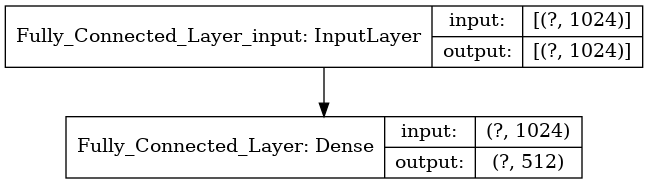

In [37]:
tf.keras.utils.plot_model(NG.compression_model, show_shapes=True, show_layer_names=True)

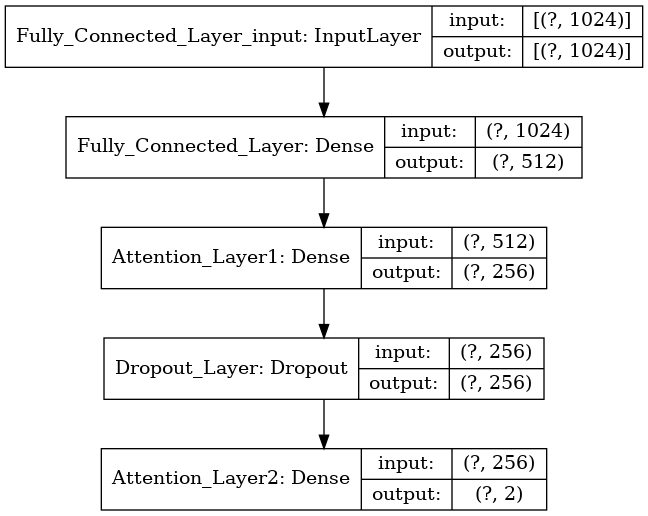

In [38]:
tf.keras.utils.plot_model(NG.att_model_no_gate(), show_shapes=True, show_layer_names=True)

### Architecture of Gated Attention Network

In [39]:
G = G_Att_Net(dim_features=1024, dim_compress_features=512, n_hidden_units=256,
                                      n_classes=2, dropout=True, dropout_rate=.25)

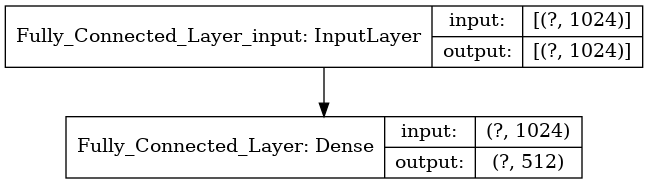

In [40]:
tf.keras.utils.plot_model(G.compression_model, show_shapes=True, show_layer_names=True)

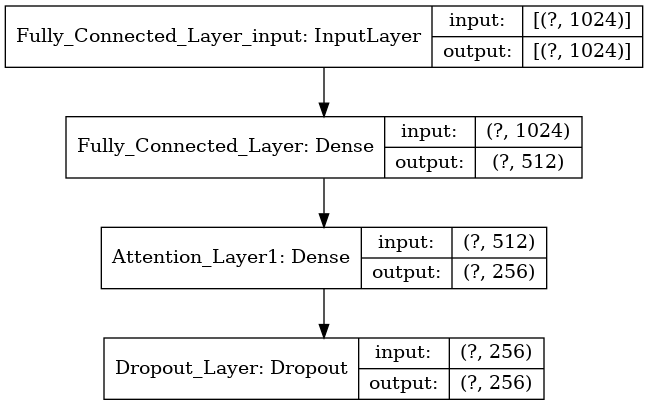

In [41]:
tf.keras.utils.plot_model(G.att_model_gate()[0], show_shapes=True, show_layer_names=True)

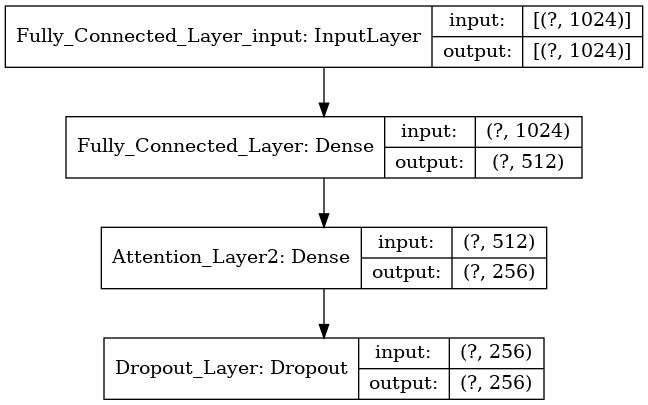

In [42]:
tf.keras.utils.plot_model(G.att_model_gate()[1], show_shapes=True, show_layer_names=True)

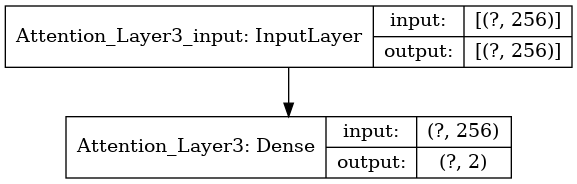

In [43]:
tf.keras.utils.plot_model(G.att_model_gate()[2], show_shapes=True, show_layer_names=True)

### Architecture of Bag Classifier Model

In [44]:
bag = tf.keras.models.Sequential(tf.keras.layers.Dense(units=1, activation='linear', input_shape=(512,)))

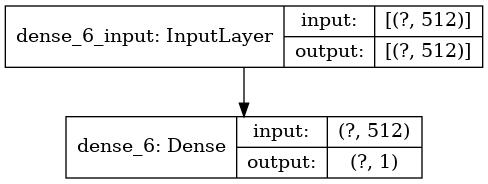

In [45]:
tf.keras.utils.plot_model(bag, show_shapes=True, show_layer_names=True)

### Architecture of Instance Classifier Model

In [46]:
instance = tf.keras.models.Sequential(tf.keras.layers.Dense(units=2, activation='linear', input_shape=(512,)))

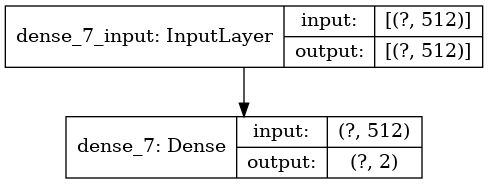

In [47]:
tf.keras.utils.plot_model(instance, show_shapes=True, show_layer_names=True)

<br>

## Train CLAM Model

### Load Training Data

In [48]:
train_data = '/research/bsi/projects/PI/tertiary/Hart_Steven_m087494/s211408.DigitalPathology/Quincy/Data/CLAM/train/'
val_data = '/research/bsi/projects/PI/tertiary/Hart_Steven_m087494/s211408.DigitalPathology/Quincy/Data/CLAM/valid/'
test_data = '/research/bsi/projects/PI/tertiary/Hart_Steven_m087494/s211408.DigitalPathology/Quincy/Data/CLAM/test/'

### Prohibit Tensorflow Warning Messages

In [49]:
def tf_shut_up(no_warn_op=False):
    if no_warn_op:
        tf.get_logger().setLevel('ERROR')
    else:
        print('Are you sure you want to receive the annoying TensorFlow Warning Messages?', '\n', 'If not, check the value of your input prameter for this function and re-run it.')

### Train CLAM Model on the Given Training Data

In [57]:
def train_step(model, train_path, learn_rate=2e-04, l2_decay=1e-05):
    """
    Input Arg:
        train_path -> path of the training data
    """
    optimizer = tfa.optimizers.AdamW(learning_rate=learn_rate, weight_decay=l2_decay)

    acc_func = tf.keras.metrics.BinaryAccuracy()
    auc_func = tf.keras.metrics.AUC()   
    tp_func = tf.keras.metrics.TruePositives()
    fp_func = tf.keras.metrics.FalsePositives()
    tn_func = tf.keras.metrics.TrueNegatives()
    fn_func = tf.keras.metrics.FalseNegatives()
    precision_func = tf.keras.metrics.Precision()
    recall_func = tf.keras.metrics.Recall()

    loss_total = list()
    loss_patch = list()
    loss_bag = list()
    acc = list()
    auc = list()
    precision = list()
    recall = list()
    
    for i in os.listdir(train_path):
        print('=', end = "")
        single_train_data = train_path + i
        img_features, slide_label = get_data_from_tf(single_train_data)
        slide_true = tf.one_hot([slide_label],2)   # one-hot encoding for ground-truth slide_label that is compatible with Y-Prob
  
        train_tp = 0
        train_fp = 0
        train_tn = 0
        train_fn = 0
        
        train_acc = 0.0
        train_auc = 0.0
        train_precision = 0.0
        train_recall = 0.0
    
        with tf.GradientTape() as tape:
            att_net_out, pseudo_labels, logits, slide_score_unnorm, Y_hat, Y_prob = model.call(img_features, slide_label)
            slide_pred = Y_prob
            patch_loss = list()
            for i in range(16):
                pl = tf.keras.losses.hinge(pseudo_labels[i], logits[i])
                patch_loss.append(pl)
            patch_loss_total = tf.math.add_n(patch_loss) / 16
            bag_loss_total = tf.keras.losses.binary_crossentropy(slide_true, slide_pred)
            loss = tf.math.reduce_sum(0.7*patch_loss_total+0.3*bag_loss_total) / 2
            
        clam_grad = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(clam_grad, model.trainable_variables)) 
        
        loss_total.append(loss)
        loss_patch.append(patch_loss_total)
        loss_bag.append(bag_loss_total)
        
        tp = tp_func(slide_true, slide_pred)
        fp = fp_func(slide_true, slide_pred)
        tn = tn_func(slide_true, slide_pred)
        fn = fn_func(slide_true, slide_pred)
        
        #acc_value = acc_func(slide_true, slide_pred)
        auc_value = auc_func(slide_true, slide_pred)
        precision_value = precision_func(slide_true, slide_pred)
        recall_value = recall_func(slide_true, slide_pred)
        
        train_tp += tp
        train_fp += fp
        train_tn += tn
        train_fn += fn
        
        #train_acc += acc_value
        train_acc += acc_func(slide_true, slide_pred)
        train_auc += auc_value
        train_precision += precision_value
        train_recall += recall_value
        
        acc.append(train_acc)
        auc.append(train_auc)
        precision.append(train_precision)
        recall.append(train_recall)
    acc_train = tf.math.add_n(acc) / len(os.listdir(train_path))
    auc_train = tf.math.add_n(auc) / len(os.listdir(train_path))
    precision_train = tf.math.add_n(precision) / len(os.listdir(train_path))
    recall_train = tf.math.add_n(recall) / len(os.listdir(train_path))
    train_loss = tf.math.add_n(loss_total) / len(os.listdir(train_path))
    train_pl = tf.math.add_n(loss_patch) / len(os.listdir(train_path))
    train_bl = tf.math.add_n(loss_bag) / len(os.listdir(train_path))
    
    #train_acc = tf.math.add_n(acc) / len(os.listdir(train_path))
    train_auc = tf.math.add_n(auc) / len(os.listdir(train_path))
    train_precision = tf.math.add_n(precision) / len(os.listdir(train_path))
    train_recall = tf.math.add_n(recall) / len(os.listdir(train_path))
            
    print('\n', 'Instance Loss is: ', train_pl, 'Slide Loss is: ', train_bl, 'Total Loss is: ', train_loss, 'acc is: ', acc_train, 'AUC is ', auc_train, 'TP is', train_tp, 'FP is ', train_fp, 'TN is ', train_tn, 
          'FN is ', train_fn, 'Precision is ', precision_train, 'Recall is ', recall_train, '\n')
        
    train_out = {
        'Training Loss': train_loss, 'Training Accuracy': train_acc, 'Training AUC': train_auc, 'Training True Positives': train_tp, 'Training False Positives': train_fp,
        'Training True Negatives': train_tn, 'Training False Negatives': train_fn, 'Training Precisions': train_precision, 'Training Recall': train_recall
        }
    
    return train_out

### Validating CLAM Model

In [58]:
def val_step(model, val_path):
    """
    Input Arg:
        val_path -> path of the validation data
    """
    acc_func = tf.keras.metrics.BinaryAccuracy()
    auc_func = tf.keras.metrics.AUC()   
    tp_func = tf.keras.metrics.TruePositives()
    fp_func = tf.keras.metrics.FalsePositives()
    tn_func = tf.keras.metrics.TrueNegatives()
    fn_func = tf.keras.metrics.FalseNegatives()
    precision_func = tf.keras.metrics.Precision()
    recall_func = tf.keras.metrics.Recall()
    
    loss_total = list()
    acc = list()
    auc = list()
    precision = list()
    recall = list()
    
    for j in os.listdir(val_path):
        print('=', end = "")
        single_val_data = val_path + j
        img_features, slide_label = get_data_from_tf(single_val_data)
        slide_true = tf.one_hot([slide_label],2)   # one-hot encoding for ground-truth slide_label that is compatible with Y-Prob

        att_net_out, pseudo_labels, logits, slide_score_unnorm, Y_hat, Y_prob = model.call(img_features, slide_label)
        slide_pred = Y_prob
        patch_loss = list()
        for i in range(16):
            pl = tf.keras.losses.hinge(pseudo_labels[i], logits[i])
            patch_loss.append(pl)
        patch_loss_total = tf.math.add_n(patch_loss) / 16
        bag_loss_total = tf.keras.losses.binary_crossentropy(slide_true, slide_pred)
        loss = tf.math.reduce_sum(0.7*patch_loss_total+0.3*bag_loss_total) / 2
          
        val_tp = 0
        val_fp = 0
        val_tn = 0
        val_fn = 0
        
        val_acc = 0.0
        val_auc = 0.0
        val_precision = 0.0
        val_recall = 0.0
        
        tp = tp_func(slide_true, slide_pred)
        fp = fp_func(slide_true, slide_pred)
        tn = tn_func(slide_true, slide_pred)
        fn = fn_func(slide_true, slide_pred)
        
        acc_value = acc_func(slide_true, slide_pred)
        auc_value = auc_func(slide_true, slide_pred)
        precision_value = precision_func(slide_true, slide_pred)
        recall_value = recall_func(slide_true, slide_pred)
        
        val_tp += tp
        val_fp += fp
        val_tn += tn
        val_fn += fn
        
        val_acc += acc_value
        val_auc += auc_value
        val_precision += precision_value
        val_recall += recall_value
        
        acc.append(val_acc)
        auc.append(val_auc)
        precision.append(val_precision)
        recall.append(val_recall)
        
        loss_total.append(loss)

    val_loss = tf.math.add_n(loss_total) / len(os.listdir(val_path))
    
    val_acc = tf.math.add_n(acc) / len(os.listdir(val_path))
    val_auc = tf.math.add_n(auc) / len(os.listdir(val_path))
    val_precision = tf.math.add_n(precision) / len(os.listdir(val_path))
    val_recall = tf.math.add_n(recall) / len(os.listdir(val_path))
            
    print('\n', 'Validation Loss is: ', val_loss, 'acc is: ', val_acc, 'AUC is ', val_auc, 'TP is', val_tp, 'FP is ', val_fp, 'TN is ', val_tn, 'FN is ', val_fn, 
          'Precision is ', val_precision, 'Recall is ', val_recall, '\n')
        
    val_out = {
        'Validation Loss': val_loss, 'Validation Accuracy': val_acc, 'Validation AUC': val_auc, 'Validation True Positives': val_tp, 'Validation False Positives': val_fp,
        'Validation True Negatives': val_tn, 'Validation False Negatives': val_fn, 'Validation Precisions': val_precision, 'Validation Recall': val_recall
        }
        
    return val_out    

## Optimizing CLAM Model

In [59]:
clam = CLAM(att_net_gate=True, net_size_arg='small', n_instance_sample=8, n_classes=2, subtype_prob=False,
                 dropout=False, dropout_rate=.25, mil_op=True, att_only_op=False)

In [60]:
def clam_develop(epochs=1):
    for epoch in range(epochs):
        print('Beginning Training Epoch', epoch+1, '\n')
        train_step(model=clam, train_path=train_data, learn_rate=2e-04, l2_decay=1e-05)
        print('Beginning Validation Epoch', epoch+1, '\n')
        val_step(model=clam, val_path=val_data)  

In [61]:
tf.get_logger().setLevel('ERROR')

In [ ]:
clam_develop(epochs=200)